# Music Genre Classification


Yhasmim de Souza Tigre

### Entrada de Dados
> Estou usando o dataset GTZAN (https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) que é o conjunto de dados público mais usado para avaliação em pesquisa de audição de máquina para reconhecimento de gênero musical (MGR). Os arquivos foram coletados em 2000-2001 de uma variedade de fontes, incluindo CDs pessoais, rádio, gravações de microfone, para representar uma variedade de condições de gravação

In [ ]:
!pip install -q kaggle
!pip install librosa

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip /content/gtzan-dataset-music-genre-classification.zip -d /content/gtzan-dataset-music-genre-classification

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 99% 1.20G/1.21G [00:13<00:00, 64.2MB/s]
100% 1.21G/1.21G [00:13<00:00, 94.7MB/s]
Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: /content/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv  
  inflating: /content/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv  
  inflating: /content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav  
  inflating: /content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00001.wav  
  inflating: /content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00002.wav  
  inflating: /content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.000

### Pré-processamento

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
# Caminho para a pasta onde os arquivos de áudio estão armazenados
dataset_path = '/content/gtzan-dataset-music-genre-classification'

In [ ]:
def load_audio_file(file_path):
    # Carrega o arquivo de áudio com uma taxa de amostragem de 22.050 Hz (valor comum)
    audio_data, sample_rate = librosa.load(file_path, sr=22050)
    return audio_data, sample_rate

 Mel-espectrogramas representam visualmente as frequências (ou notas) do áudio ao longo do tempo.

In [ ]:
def extract_mel_spectrogram(audio_data, sample_rate, n_mels=128, fmax=8000):
    # Calcula
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=n_mels, fmax=fmax)
    # Converte em decibéis
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

Exemplo de Mel-espectrograma

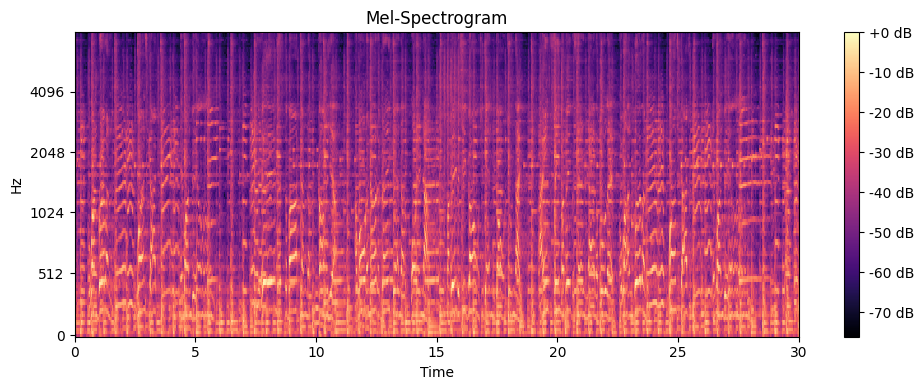

In [ ]:
# Caminho para a pasta onde os arquivos de áudio estão armazenados
genre_folder = '/content/gtzan-dataset-music-genre-classification/Data/genres_original/blues'

# Acessar um arquivo de áudio específico na pasta 'blues'
file_name = 'blues.00000.wav'  # Nome do arquivo de áudio
file_path = os.path.join(genre_folder, file_name)  # Caminho completo para o arquivo

# Carregar o áudio
audio_data, sample_rate = load_audio_file(file_path)

# Extrair o mel-espectrograma
mel_spectrogram = extract_mel_spectrogram(audio_data, sample_rate)

# Plotar o mel-espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

Padronização e Normalização

In [ ]:
def pad_or_truncate_spectrogram(spectrogram, max_length=128):
    # Se o espectrograma for maior que o tamanho máximo, corte
    if spectrogram.shape[1] > max_length:
        return spectrogram[:, :max_length]
    # Se for menor, complete com zeros
    elif spectrogram.shape[1] < max_length:
        padding = max_length - spectrogram.shape[1]
        return np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')
    else:
        return spectrogram

In [ ]:
def normalize_spectrogram(spectrogram):
    return (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)

In [ ]:
base_path = '/content/gtzan-dataset-music-genre-classification/Data/genres_original'

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
X = []
Y = []
corrupted_files = []

# Processando cada gênero
for genre in genres:
    genre_folder = os.path.join(base_path, genre)
    for file_name in os.listdir(genre_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(genre_folder, file_name)
            try:
                audio_data, sample_rate = load_audio_file(file_path)
                mel_spectrogram = extract_mel_spectrogram(audio_data, sample_rate)
                mel_spectrogram_fixed = pad_or_truncate_spectrogram(mel_spectrogram)
                mel_spectrogram_normalized = normalize_spectrogram(mel_spectrogram_fixed)
                X.append(mel_spectrogram_normalized)
                Y.append(genre)
            except Exception as e:
                corrupted_files.append(file_path)
                print(f"Erro ao carregar o arquivo {file_path}: {e}")

# Converter para arrays numpy
X = np.array(X)
Y = pd.get_dummies(Y).values  # Convertendo para one-hot encoding

# Relatório sobre arquivos corrompidos
if corrupted_files:
    print(f"Número de arquivos corrompidos: {len(corrupted_files)}")
    print("Arquivos corrompidos:")
    for corrupted_file in corrupted_files:
        print(corrupted_file)
else:
    print("Nenhum arquivo corrompido encontrado.")

<ipython-input-20-7a009333879f>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro ao carregar o arquivo /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Número de arquivos corrompidos: 1
Arquivos corrompidos:
/content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav


### Modelo

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [ ]:
def prepare_dataset(test_size, validation_size, X, Y):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2, X, Y)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(128, 128, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 15, 15, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 16)          │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 90,586 (353.85 KB)

 Trainable params: 90,298 (352.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 40, batch_size = 32, callbacks=[early_stopping])

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1350 - loss: 3.0906 - val_accuracy: 0.1667 - val_loss: 2.2817
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1843 - loss: 2.3144 - val_accuracy: 0.2400 - val_loss: 2.2736
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1951 - loss: 2.2300 - val_accuracy: 0.1600 - val_loss: 2.2608
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2549 - loss: 2.0574 - val_accuracy: 0.1400 - val_loss: 2.2622
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3082 - loss: 1.9804 - val_accuracy: 0.2267 - val_loss: 2.1989
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3281 - loss: 1.8907 - val_accuracy: 0.1600 - val_loss: 2.1947
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4002 - loss: 1.7567 - val_accuracy: 0.1800 - val_loss: 2.1761
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3751 - loss: 1.7572 - val_accuracy: 0.2467 - val_loss:

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

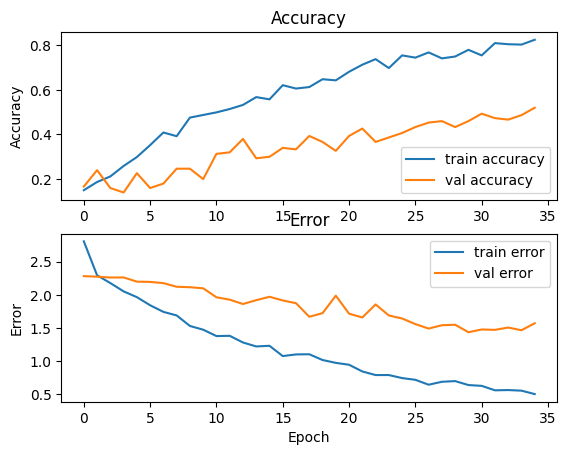

In [ ]:
plot_history(hist)

In [ ]:
# Previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Acurácia: {accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 760ms/step
Acurácia: 0.46


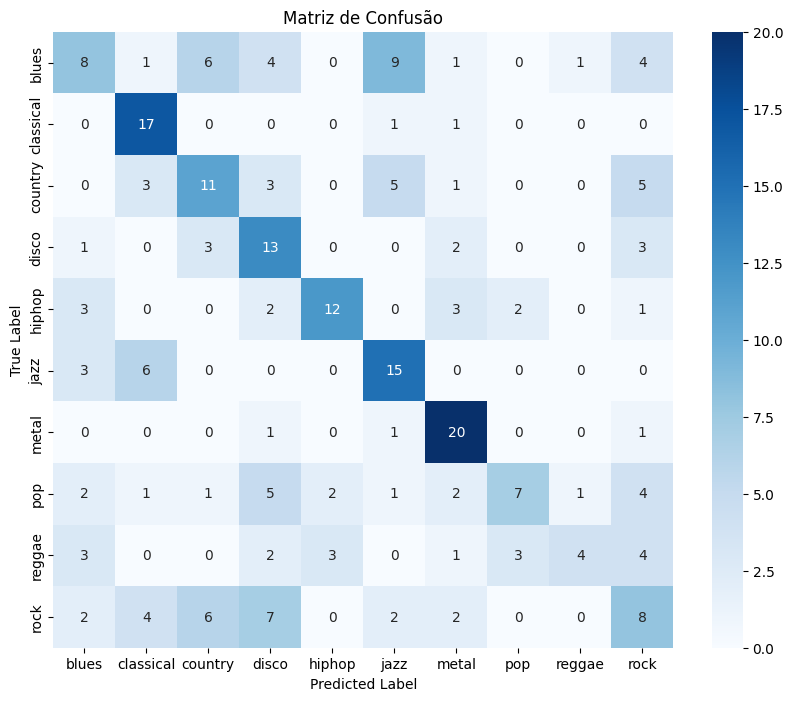

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusão')
plt.show()


In [ ]:
# Relatório de classificação
print(classification_report(y_true_classes, y_pred_classes, target_names=genres))


              precision    recall  f1-score   support

       blues       0.36      0.24      0.29        34
   classical       0.53      0.89      0.67        19
     country       0.41      0.39      0.40        28
       disco       0.35      0.59      0.44        22
      hiphop       0.71      0.52      0.60        23
        jazz       0.44      0.62      0.52        24
       metal       0.61      0.87      0.71        23
         pop       0.58      0.27      0.37        26
      reggae       0.67      0.20      0.31        20
        rock       0.27      0.26      0.26        31

    accuracy                           0.46       250
   macro avg       0.49      0.49      0.46       250
weighted avg       0.48      0.46      0.44       250

